Generic Dataset Information

Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses.

    Charge profile:
        The charge profile for all battery tests seems to be identifical.
        Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA.

    Discharge:
        Discharge profiles were different from battery to battery.
        Discharge was carried out at a constant current (CC) level of 1-4 A until the battery voltage fell to values such 2.7V, 2.5V, 2.2V and 2.5V.

    Impedance:
        Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

The experiments were stopped when the batteries reached a given end-of-life (EOL) criteria: for example 30% fade in rated capacity (from 2Ahr to 1.4Ahr). Other stopping criteria were used such as 20% fade in rated capacity. Note that for batteries 49,50,51,52, the experiments were not stop due to battery EOL but because the software has crashed.


Structure of .mat files

    dictionary (loaded mat file)
        dictionary (e.g. B0005)
            list (cycle) -> one test per element in the list
                element of the list = dict = all data for one test of that battery
                    type: operation type, can be charge, discharge or impedance
                    ambient_temperature: ambient temperature (degree C)
                    time: the date and time of the start of the cycle, in MATLAB date vector format
                    data (dict): data structure containing the measurements
                        data fields with key being measured variable, values the actual records (see below)

    for charge the fields are:
        Voltage_measured: Battery terminal voltage (Volts) -> terminal voltage is the voltage or potential difference between the positive and the negative terminals of the battery
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_charge: Current measured at charger (Amps)
        Voltage_charge: Voltage measured at charger (Volts)
        Time: Time vector for the cycle (secs)
    for discharge the fields are:
        Voltage_measured: Battery terminal voltage (Volts)
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_load: Current measured at load (Amps)
        Voltage_load: Voltage measured at load (Volts)
        Time: Time vector for the cycle (secs)
        Capacity: Battery capacity (Ahr) for discharge till 2.7V
    for impedance the fields are:
        Sense_current: Current in sense branch (Amps)
        Battery_current: Current in battery branch (Amps)
        Current_ratio: Ratio of the above currents
        Battery_impedance: Battery impedance (Ohms) computed from raw data
        Rectified_impedance: Calibrated and smoothed battery impedance (Ohms)
        Re: Estimated electrolyte resistance (Ohms)
        Rct: Estimated charge transfer resistance (Ohms)

Differences between README files

    discharge CC level
    discharge runs stopped voltage
    EOL criteria (30% -> 1.4 Ah, 20% -> 1.6 Ah, software crash)


In [198]:
import numpy as np
import pandas as pd
import scipy.io as sio

In [199]:
def load_mat(filepath):
    return sio.loadmat(filepath, simplify_cells=True)

In [200]:
mat = load_mat("data/B0005.mat")

In [201]:
new_l = []
for i in range(len(mat['B0005']['cycle'])):
    new_l.append(mat['B0005']['cycle'][i]['type'])
new_l

['charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'discharge',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge',
 'impedance',
 'charge',
 'impedance',
 'discharge'

In [202]:
df_c0 = pd.DataFrame(data=mat['B0005']['cycle'][0]['data'])

In [203]:
df_c0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      789 non-null    float64
 1   Current_measured      789 non-null    float64
 2   Temperature_measured  789 non-null    float64
 3   Current_charge        789 non-null    float64
 4   Voltage_charge        789 non-null    float64
 5   Time                  789 non-null    float64
dtypes: float64(6)
memory usage: 37.1 KB


In [204]:
import matplotlib.pyplot as plt


def plot_test_data(df, profile="charge"):
    if profile == 'charge':
        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Voltage_charge, 'b', label='Voltage_charge')
        plt.plot(df.Time, df.Current_charge, 'r', label='Current_charge')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile == 'discharge':
        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Voltage_load, 'b', label='Voltage_load')
        plt.plot(df.Time, df.Current_load, 'r', label='Current_load')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile == 'impedance':
        pass
    else:
        print('No cycle recognized')

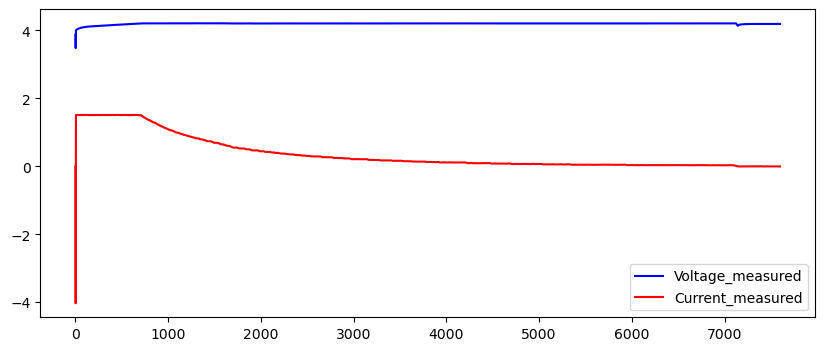

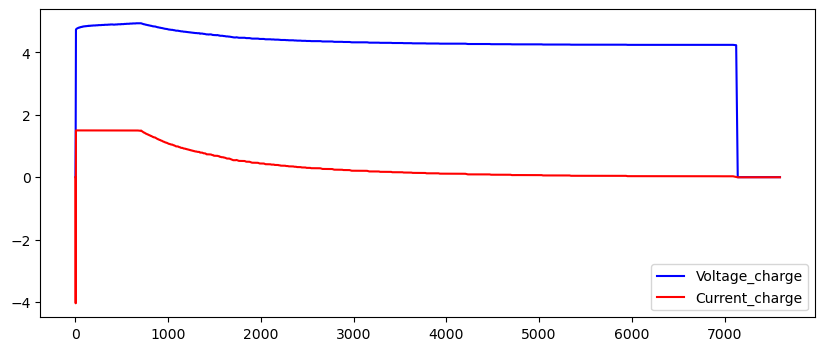

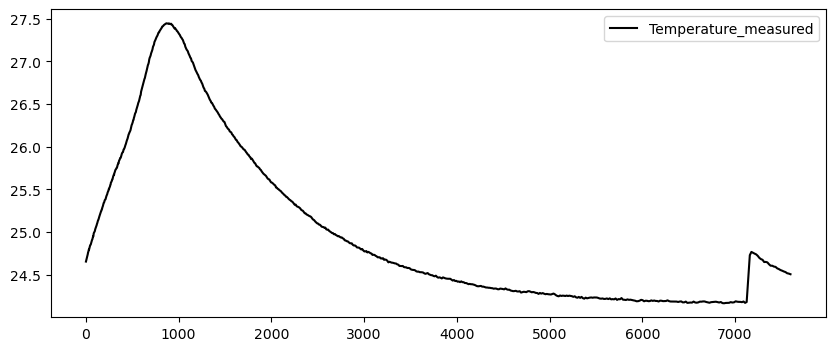

In [205]:
plot_test_data(df_c0)

In [206]:
df_c1 = pd.DataFrame(data=mat['B0005']['cycle'][1]['data'])
df_c1.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487


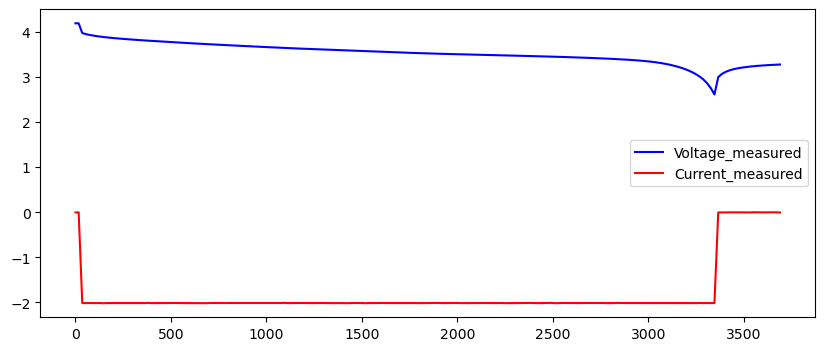

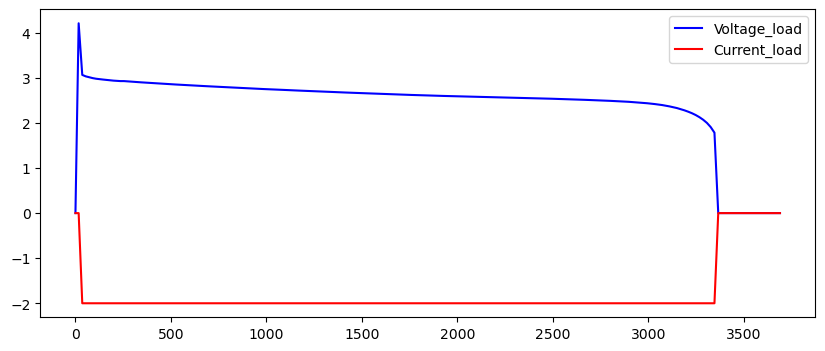

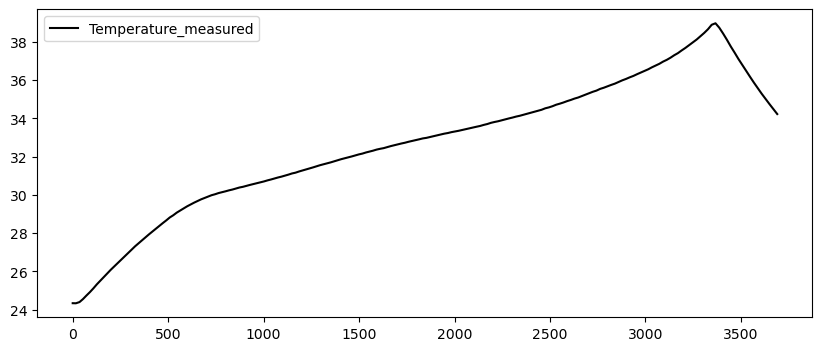

In [207]:
plot_test_data(df_c1, profile='discharge')

## Test

In [208]:
b5 = load_mat("data/B0005.mat")
b5_cycles = b5['B0005']['cycle']

In [209]:
charge_dfs = []
discharge_dfs = []
c = 0
d = 0

for cycle_number in range(len(b5_cycles)):
    cycle_type = b5_cycles[cycle_number]['type']
    cycle_data = b5_cycles[cycle_number]['data']

    if cycle_type == 'charge':
        c = c + 1

        df = pd.DataFrame({
            'Cycle': c,  # Add the cycle number as a column
            'Time': cycle_data['Time'],
            'Voltage_measured': cycle_data['Voltage_measured'],
            'Current_measured': cycle_data['Current_measured'],
            'Temperature_measured': cycle_data['Temperature_measured'],
            'Current_charge': cycle_data['Current_charge'],
            'Voltage_charge': cycle_data['Voltage_charge'],
        })

        charge_dfs.append(df)
    if cycle_type == 'discharge':
        d = d + 1

        df = pd.DataFrame({
            'Cycle': d,
            'Time': cycle_data['Time'],
            'Voltage_measured': cycle_data['Voltage_measured'],
            'Current_measured': cycle_data['Current_measured'],
            'Temperature_measured': cycle_data['Temperature_measured'],
            'Current_load': cycle_data['Current_load'],
            'Voltage_load': cycle_data['Voltage_load'],
            'Capacity': cycle_data['Capacity']
        })

        discharge_dfs.append(df)

In [210]:
charge_df = pd.concat(charge_dfs, ignore_index=True)
charge_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753


In [211]:
discharge_df = pd.concat(discharge_dfs, ignore_index=True)
discharge_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Capacity
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487
2,1,35.703,3.974871,-2.012528,24.389085,-1.9982,3.062,1.856487
3,1,53.781,3.951717,-2.013979,24.544752,-1.9982,3.030,1.856487
4,1,71.922,3.934352,-2.011144,24.731385,-1.9982,3.011,1.856487


In [212]:
# import matplotlib.pyplot as plt
# import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# 
# x = charge_df['Cycle']
# y = charge_df['Time']
# x, y = np.meshgrid(x, y)
# z = charge_df['Voltage_measured']
# 
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# 
# surf = ax.plot_surface(x, y, z, cmap='coolwarm')
# 
# ax.set_xlabel('Cycle')
# ax.set_ylabel('Time (secs)')
# ax.set_zlabel('Voltage Measured (Volts)')
# 
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
# 
# plt.show()

In [213]:
initial_capacity = discharge_df['Capacity'].iloc[0]
discharge_df['SOH'] = discharge_df['Capacity'] / initial_capacity
discharge_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Capacity,SOH
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,1.0
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,1.0
2,1,35.703,3.974871,-2.012528,24.389085,-1.9982,3.062,1.856487,1.0
3,1,53.781,3.951717,-2.013979,24.544752,-1.9982,3.030,1.856487,1.0
4,1,71.922,3.934352,-2.011144,24.731385,-1.9982,3.011,1.856487,1.0


In [214]:
max_discharge_df = discharge_df.loc[discharge_df.groupby('Cycle')['Time'].idxmax()]
max_discharge_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Capacity,SOH
196,1,3690.234,3.277170,-0.006528,34.230853,-0.0006,0.0,1.856487,1.000000
392,2,3672.344,3.300245,-0.000448,34.392137,-0.0006,0.0,1.846327,0.994527
587,3,3651.641,3.327451,0.001026,34.232779,-0.0006,0.0,1.835349,0.988614
781,4,3631.563,3.314182,-0.002234,34.413450,-0.0006,0.0,1.835263,0.988567
975,5,3629.172,3.305497,0.000009,34.345885,-0.0006,0.0,1.834646,0.988235
...,...,...,...,...,...,...,...,...,...
49092,164,2793.390,3.615561,-0.002548,34.075649,0.0006,0.0,1.293464,0.696726
49389,165,2793.390,3.621191,-0.002460,33.991350,0.0006,0.0,1.288003,0.693785
49686,166,2792.485,3.619185,0.000478,34.059198,0.0006,0.0,1.287453,0.693488
49984,167,2802.016,3.595365,-0.002342,34.556514,0.0006,0.0,1.309015,0.705103


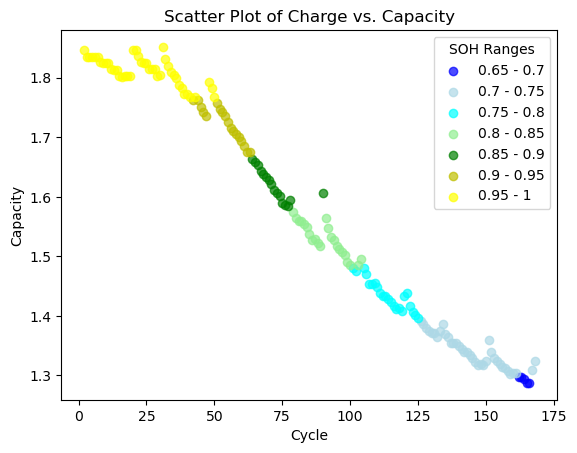

In [215]:
colors = {
    (0.65, 0.7): 'blue',
    (0.7, 0.75): 'lightblue',
    (0.75, 0.8): 'aqua',
    (0.8, 0.85): 'lightgreen',
    (0.85, 0.9): 'green',
    (0.9, 0.95): 'y',
    (0.95, 1): 'yellow',
}

for (lower, upper), color in colors.items():
    mask = (max_discharge_df['SOH'] >= lower) & (max_discharge_df['SOH'] < upper)

    plt.scatter(
        max_discharge_df[mask]['Cycle'],
        max_discharge_df[mask]['Capacity'],
        c=color,
        label=f'{lower} - {upper}',
        alpha=0.7
    )

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Scatter Plot of Charge vs. Capacity')
plt.legend(title='SOH Ranges')
plt.show()

In [216]:
y = max_discharge_df['SOH']
X = max_discharge_df.drop(['SOH', 'Capacity', 'Cycle'], axis=1)

In [217]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')  # You can use other kernels like 'linear' or 'poly' if needed
model.fit(X_train, y_train)

SVR()

In [219]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.01


In [220]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3],
    'gamma': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVR(), parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.01}


In [221]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

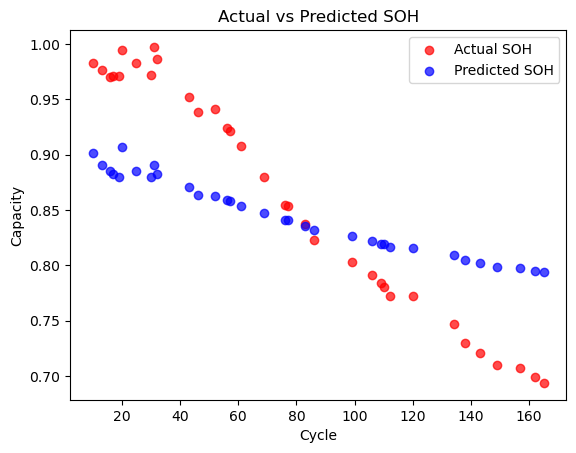

In [222]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

In [223]:
new_df = max_discharge_df.copy()

model = SVR(kernel='rbf')
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred

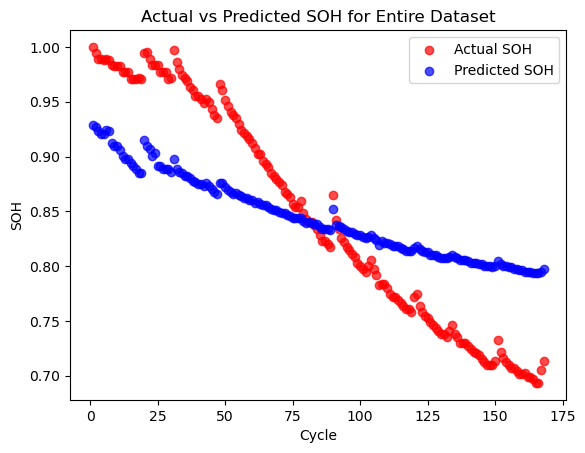

In [224]:
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()

In [225]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [226]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 0.99


In [227]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

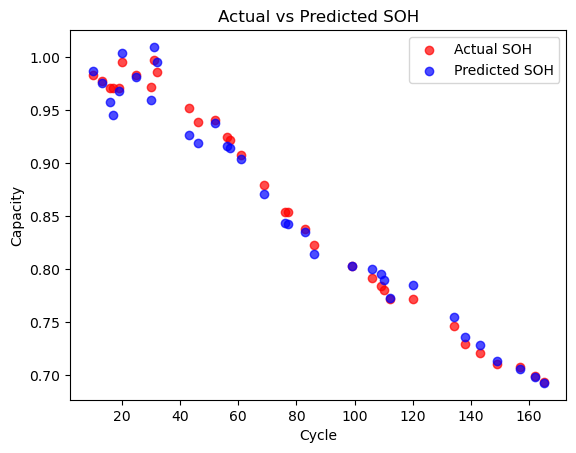

In [228]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

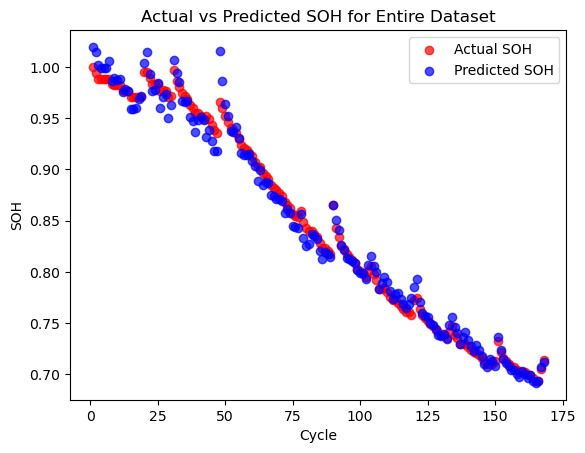

In [229]:
new_df = max_discharge_df.copy()

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()